## Lights Out Problem Solution

### Importing the required modules

Imporitng all the modules and libraries

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import IBMQ, execute
from qiskit import *
from qiskit.visualization import plot_histogram
import time

# warning import is not necessary for program execution. Its just to supress the unwanted warning thrown by the 
# qiskit backend.
import warnings

warnings.filterwarnings('ignore')

### Setting the backend for execution

Below cell sets the backend for the program execution.
Apart from the qasm_simulator, other devices are also available which include various Quantum Devices. But the maximum capacity of a Quantum Computer is 15 Qubits which is much less than what is required. Thus selecting the simulator for our purpose which has a maximum of 32 qubit computational limit for general purpose use. 

In [2]:
# Enter your IBMQ account ID below for the purpose of execution and then uncomment the statement

# IBMQ.save_account('',overwrite=True) 
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

### Initializing the qubits and classical bits 

Initializing all the required qubits and classical bits. In total 26 quantum bits and 9 classical bits are required.

Lights arrangement on the board at the start of the problem
Given as:

[1 0 1        
 0 1 0        
 1 0 1]       

The above light arrangement can be changed as per the initial lights condition on the board.

In [3]:
tile = QuantumRegister(9,name='tile')
flip = QuantumRegister(9,name='flip')
oracle = QuantumRegister(1,name='oracle')
auxiliary = QuantumRegister(7,name='auxiliary')
result = ClassicalRegister(9,name='result')
qc = QuantumCircuit(tile, flip, oracle, auxiliary, result)


# (0) | (1) | (2)
# - - - - - - - -  
# (3) | (4) | (5)
# - - - - - - - - 
# (6) | (7) | (8)

initial_lights = [1, 0, 1, 0, 1, 0, 1, 0, 1]

### Declaring and defining the Tile flipping circuit

It is a circuit required for oracle. This is to calculate the state of light on board after pressing each tile.
Example:
After pressing [0], then the tile itself along with its neighbouring tile will get flipped.
Thus, after pressing [0] tile, the [1] and [3] tiles get flipped
This circuit is then converted into a qiskit gate. This gate is then used in the algorithm by the name 'Flip_tile'. 

In [4]:
Tile = QuantumRegister(9)
Flip = QuantumRegister(9)
circuit = QuantumCircuit(Tile,Flip,name='Flip Tile')    
#For tile 0,0
circuit.cx(Flip[0], Tile[0]) 
circuit.cx(Flip[0], Tile[1])
circuit.cx(Flip[0], Tile[3])
#----------------------------------------
#For tile 0,1
circuit.cx(Flip[1], Tile[0])
circuit.cx(Flip[1], Tile[1])
circuit.cx(Flip[1], Tile[2])
circuit.cx(Flip[1], Tile[4])
#----------------------------------------
#For tile 0,2
circuit.cx(Flip[2], Tile[1])
circuit.cx(Flip[2], Tile[2])
circuit.cx(Flip[2], Tile[5])
#----------------------------------------
#For tile 1,0
circuit.cx(Flip[3], Tile[0])
circuit.cx(Flip[3], Tile[3])
circuit.cx(Flip[3], Tile[4])
circuit.cx(Flip[3], Tile[6])
#----------------------------------------
#For tile 1,1
circuit.cx(Flip[4], Tile[1])
circuit.cx(Flip[4], Tile[3])
circuit.cx(Flip[4], Tile[4])
circuit.cx(Flip[4], Tile[5])
circuit.cx(Flip[4], Tile[7])
#----------------------------------------
#For tile 1,2
circuit.cx(Flip[5], Tile[2])
circuit.cx(Flip[5], Tile[4])
circuit.cx(Flip[5], Tile[5])
circuit.cx(Flip[5], Tile[8])
#----------------------------------------
#For tile 2,0
circuit.cx(Flip[6], Tile[3])
circuit.cx(Flip[6], Tile[6])
circuit.cx(Flip[6], Tile[7])
#----------------------------------------
#For tile 2,1
circuit.cx(Flip[7], Tile[4])
circuit.cx(Flip[7], Tile[6])
circuit.cx(Flip[7], Tile[7])
circuit.cx(Flip[7], Tile[8])
#----------------------------------------
#For tile 2,2
circuit.cx(Flip[8], Tile[5])
circuit.cx(Flip[8], Tile[7])
circuit.cx(Flip[8], Tile[8])
#circuit.draw()
Flip_tile = circuit.to_gate()

### Defining the Oracle function circuit

The below cell defines the Oracle circuit and then converts it into a qiskit gate. This gate is then used in the actual algorithm by the name 'Oracle_gate'.

In [5]:
Tile = QuantumRegister(9)
Flip = QuantumRegister(9)
OracleQubit = QuantumRegister(1)
Auxiliary = QuantumRegister(7)
Oraclecircuit = QuantumCircuit(tile, flip, oracle, auxiliary,name='Oracle Function')

Oraclecircuit.append(Flip_tile,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
Oraclecircuit.x(tile[0:9])
Oraclecircuit.mct(tile[0:9], oracle[0], auxiliary[0:7], mode='basic')
Oraclecircuit.x(tile[0:9])
Oraclecircuit.append(Flip_tile,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

Oracle_gate = Oraclecircuit.to_gate()

### Defining the Diffusion function circuit

The below cell defines the diffusion circuit and then converts it into a qiskit gate. This gate is then used in the actual algorithm by the name 'Diffusion_gate'.

In [6]:
Flip = QuantumRegister(9)
OracleQubit = QuantumRegister(1)
Auxiliary = QuantumRegister(7)
Diffusioncircuit = QuantumCircuit(Flip, OracleQubit, Auxiliary,name='Diffusion Function')

Diffusioncircuit.h(Flip)
Diffusioncircuit.x(Flip)
Diffusioncircuit.h(Flip[8])
Diffusioncircuit.mct(Flip[0:8], Flip[8], Auxiliary[0:7], mode='basic')
Diffusioncircuit.h(Flip[8])
Diffusioncircuit.x(Flip)
Diffusioncircuit.h(Flip)

Diffusion_gate = Diffusioncircuit.to_gate()

To print the above individual custom gates i.e. Flip_tile, Oracle_gate, Diffuion_gate uncomment the respective lines of code in the below cell

In [7]:
# circuit.draw() 
# Oraclecircuit.draw() 
# Diffusioncircuit.draw() 

### Steps for the Algorithm  

This cell states the actual steps of the algorithm. It also defines the Oracle and diffusion function. later the qubits needsto be reversed so as to alight the order of qubits for output.

The quantum circuit can be printed if required just by uncommenting the qc.draw(), before executing the cell. 

In [8]:
counter = 0
for i in initial_lights:
    if i==1:
        qc.x(tile[counter])
        counter+=1
    else:
        counter+=1
qc.h(flip[0:9])
qc.x(oracle[0])
qc.h(oracle[0]) 
qc.barrier()

# The Oracle and Diffusion function is repeated 17 times.
for i in range(17):
    
    #flip_tile(qc,flip,tile)
    qc.append(Oracle_gate,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

    # diffusion function 
    qc.append(Diffusion_gate,[9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
qc.barrier()

# Uncompute Unit
qc.h(oracle[0])
qc.x(oracle[0])
qc.barrier()

# Measuremnt 
qc.measure(flip,result)

# Reverse the order fo output to match the Input.
qc = qc.reverse_bits()

# Drawing the quantum circuit
# For drawing the final circuit uncomment the below line
# qc.draw() 

### Executing the program on the quantum device

Setting up the job for execution on quantum simulator.
Transpiler optimization level can be changed to reduce the cost. Currently the level is default i.e. no optimization but 
it can be changed as per requirement. Allowable range for the optimization_level parameter is 0-3
Maximum shots available on qasm_simulator are 8192.

In [9]:
start = time.time()
job = execute(qc, backend=backend, shots=8192, seed_simulator=1000)#, optimization_level =3)
end = time.time()
print(end-start)

4.500035285949707


### Result and Visualization

Below cell prints all the output states and their counts. Furthermore, it also prints the histogram of the states for visualization purpose. 

{'101010101': 1, '110000011': 1, '110110010': 1, '111000011': 1, '111111111': 8188}


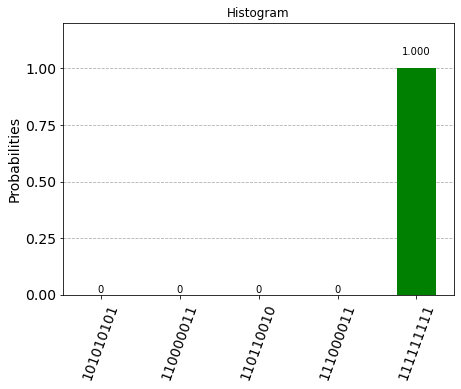

In [10]:
result = job.result()
count = result.get_counts()

print(count)

# Plotting the histogram for puspose of visuzlization 
plot_histogram(job.result().get_counts(), color='green', title="Histogram")